# **Lab 3: The BB84 Protocol**
---

### **Description**
In this notebook, we will apply our cirq skills to implement the BB84 Quantum Key Distribution Protocol.

<br>

### **Structure**
**Part 1**: [Implementing BB84 with Cirq](#p1)

**Part 2**: [Challenge Problem](#p2)


<br>

### **Resources**
* [Cirq Basics Cheat Sheet](https://docs.google.com/document/d/1Ir1qtXS2-C_tGThk00P1fZfZjoC8oet4N9Rtkw7LgVY/edit?usp=drive_link)
* [BB84 with Alice and Bob in Cirq Cheat Sheet](https://docs.google.com/document/d/1VQHFhKWTgCWchwPECMBe_LDGEzn8hu4t1uq1P44yVMY/edit)

<br>

**Before starting, run the code below to import all necessary functions and libraries.**


In [ ]:
# @title
import warnings
warnings.filterwarnings('ignore')


try:
    import cirq
except ImportError:
    print('installing cirq...')
    !pip install cirq --quiet
    import cirq
    print('installed cirq.')


#!git clone https://github.com/the-codingschool/bb84.git
#from bb84.bb84 import BB84
from cirq import NamedQubit, Simulator, Circuit

class BB84:

    """
    Implements the BB84 protocol for quantum key distribution.

    The BB84 protocol allows two parties, Alice and Bob, to generate a shared secret key, which can then be used
    for secure communication. The protocol also involves checking for the presence of an eavesdropper, Eve.
    This implementation provides a simulated environment for the protocol's execution, including the potential
    interception by Eve.


    <b>NOTE</b>:
        This class requires external definitions for the quantum circuits and simulator to function properly.

    <br>

    © 2024 The Coding School, All rights reserved.
    """

    qubit: NamedQubit
    """The qubit being used for the protocol. Must be defined externally, for example:
    ```python
    protocol.qubit = cirq.NamedQubit('q0')
    ```
    """

    simulator: Simulator
    """The quantum circuit simulator. Must be defined externally, for example:
    ```python
    protocol.simulator = cirq.Simulator()
    ```
    """

    alice_send_0_no_H_circuit: Circuit
    """The quantum circuit that Alice will use to encode a 0 without an H gate. Must be defined externally, for example:
    ```python
    protocol.alice_send_0_no_H_circuit = cirq.Circuit()
    ```
    """

    alice_send_1_no_H_circuit: Circuit
    """The quantum circuit that Alice will use to encode a 1 without an H gate. Must be defined externally, for example:
    ```python
    protocol.alice_send_1_no_H_circuit = cirq.Circuit()
    ```
    """

    alice_send_0_H_circuit: Circuit
    """The quantum circuit that Alice will use to encode a 0 with an H gate. Must be defined externally, for example:
    ```python
    protocol.alice_send_0_H_circuit = cirq.Circuit()
    ```
    """

    alice_send_1_H_circuit: Circuit
    """The quantum circuit that Alice will use to encode a 1 with an H gate. Must be defined externally, for example:
    ```python
    protocol.alice_send_1_H_circuit = cirq.Circuit()
    ```
    """

    eve_intercept_circuit: Circuit
    """The quantum circuit that Eve will use to intercept the qubit between Phase 1 and 2. Must be defined externally, for example:
    ```python
    protocol.eve_intercept_circuit = cirq.Circuit()
    ```
    """

    bob_receive_no_H_circuit: Circuit
    """The quantum circuit that Bob will use to receive and measure the qubit during Phase 3 without using an H gate. Must be defined externally, for example:
    ```python
    protocol.bob_receive_no_H_circuit = cirq.Circuit()
    ```
    """

    bob_receive_H_circuit: Circuit
    """The quantum circuit that Bob will use to receive and measure the qubit during Phase 3 using an H gate. Must be defined externally, for example:
    ```python
    protocol.bob_receive_H_circuit = cirq.Circuit()
    ```
    """


    eve_intercept: str
    """Indicates if Eve intercepts the qubits ('yes' or 'no'). Should be set upon initialization or after calling `reset()`."""

    alice_bit: int
    """The current bit Alice wants to send. Should only be modified indirectly through the `send_bit` method's parameters."""

    bob_bit: int
    """The bit received by Bob after measurement. Should only be modified indirectly through the `send_bit` method's parameters."""

    eve_bit: int
    """The bit measured by Eve if interception occurs. Should only be modified indirectly through the `send_bit` method's parameters."""

    does_alice_apply_H: str
    """Indicates if Alice applies the Hadamard gate ('yes' or 'no'). Should only be modified indirectly through the `send_bit` method's parameters."""

    does_bob_apply_H: str
    """Indicates if Bob applies the Hadamard gate ('yes' or 'no'). Should only be modified indirectly through the `send_bit` method's parameters."""


    alice_key: list
    """The secret key generated by Alice. <b>SHOULD NOT BE MODIFIED BY USER</b>."""

    bob_key: list
    """The secret key generated by Bob. <b>SHOULD NOT BE MODIFIED BY USER</b>."""

    eve_key: list
    """The key intercepted by Eve, if any. <b>SHOULD NOT BE MODIFIED BY USER</b>."""

    bit_num: int
    """Counter for the number of bits processed so far. <b>SHOULD NOT BE MODIFIED BY USER</b>."""


    def __init__(self, eve_intercept = 'no'):

      """
      Initializes the BB84 protocol simulation with default or specified settings.

      Parameters:
          `eve_intercept` (str, optional): Determines if Eve will attempt to intercept the qubits ('yes' or 'no').
                                         Defaults to 'no'.

      Example Usage:
      ```python
      protocol_without_eve = BB84()

      also_protocol_without_eve = BB84(eve_intercept = 'no')

      protocol_with_eve = BB84(eve_intercept = 'yes')
      ```
      """

      self.alice_bit = None
      self.bob_bit = None

      self.eve_bit = None
      self.eve_intercept = eve_intercept

      self.does_alice_apply_H = None
      self.does_bob_apply_H = None

      self.qubit = None
      self.simulator = None

      self.alice_send_0_no_H_circuit = None
      self.alice_send_1_no_H_circuit = None
      self.alice_send_0_H_circuit = None
      self.alice_send_1_H_circuit = None

      self.eve_intercept_circuit = None

      self.bob_receive_no_H_circuit = None
      self.bob_receive_H_circuit = None

      self.alice_key = []
      self.bob_key = []
      self.eve_key = []

      self.bit_num = 1


    def phase_1_circuit(self):

      """
      Creates a circuit such that Alice encodes her bit into a qubit and applies an H gate if she's chosen to do so.
      Then she sends this qubit through her quantum channel to Bob, hoping Eve does not intercept.

      <b>Returns</b>:
          The quantum circuit for Phase 1 of BB84 (through Alice sending her qubit).

      <b>INTERNAL USE ONLY</b>
      """

      if self.alice_bit == 0:
        if self.does_alice_apply_H == 'no':
          return self.alice_send_0_no_H_circuit
        else:
          return self.alice_send_0_H_circuit

      else:
        if self.does_alice_apply_H == 'no':
          return self.alice_send_1_no_H_circuit
        else:
          return self.alice_send_1_H_circuit


    def eve_circuit(self):

      """
      Creates a circuit for Eve's role in the protocol, which depends on if she's intercepting or not.

      <b>Returns</b>:
          The quantum circuit for Eve's interception if it occurs, otherwise an empty circuit.

      <b>INTERNAL USE ONLY</b>
      """

      if self.eve_intercept == 'yes':
        return self.eve_intercept_circuit
      else:
        return cirq.Circuit()


    def phase_2_circuit(self):

      """
      Creates a circuit such that Bob receives the qubit, applies an H gate if he's decided to do so,
      and then measures it.

      <b>Returns</b>:
          The quantum circuit for Phase 2 of BB84 (through Bob measuring the qubit).

      <b>INTERNAL USE ONLY</b>
      """

      if self.does_bob_apply_H == 'no':
        return self.bob_receive_no_H_circuit
      else:
        return self.bob_receive_H_circuit


    def restart(self):

      """
      Resets the protocol such that the circuits are all the same, but they are being used with blank keys and on a new quantum channel.
      """

      self.alice_key = []
      self.bob_key = []
      self.eve_key = []

      self.bit_num = 1


    def send_bit(self, alice_bit, does_alice_apply_H, does_bob_apply_H, compare_bits = 'no'):

      """
      Simulates the full BB84 protocol, potentially intercepted by Eve.

      Parameters:
        <ul>
          <li>`alice_bit` (int): The bit Alice wants to send.</li>
          <li>`does_alice_apply_H` (str): Indicates if Alice applies the Hadamard gate ('yes' or 'no').</li>
          <li>`does_bob_apply_H` (str): Indicates if Bob applies the Hadamard gate ('yes' or 'no').</li>
          <li>`compare_bit` (str, optional): Determines if Alice and Bob compare their bits directly ('yes' or 'no').
                                       Defaults to 'no'.</li>
        </ul>

      <b>NOTE</b>:
          This method simulates the entire process of sending a bit, including preparation, potential interception,
          and measurement. It also handles error checking for uninitialized objects that are required in the given case.


      Example Usage:
      ```python
      # Alice sends a 1 without an H gate and Bob receives and measures the qubit without an H gate.
      # The default is that they will not compare their bits and instead will add them to their key
      # if they both made the same choice of H gate or not.
      protocol.send_bit(alice_bit = 1, does_alice_apply_H = 'no', does_bob_apply_H = 'no')


      # Same as above, except Alice and Bob will compare bits instead of adding them to their key.
      protocol.send_bit(alice_bit = 1, does_alice_apply_H = 'no', does_bob_apply_H = 'no', compare_bits = 'yes')
      ```
      """

      self.alice_bit = alice_bit
      self.does_alice_apply_H = does_alice_apply_H
      self.does_bob_apply_H = does_bob_apply_H

      if self.qubit == None:
        print('Error: A qubit object must be defined first.')
        return

      elif self.simulator == None:
        print('Error: A simulator object must be defined first.')
        return


      # Prepare Alice's qubit
      alice_circuit = self.phase_1_circuit()

      if alice_circuit == None:

        applies_H = 'no H'
        if self.does_alice_apply_H == 'yes':
          applies_H = 'an H'

        print('Error: Alice\'s circuit for sending a', self.alice_bit, 'with', applies_H, 'must be defined first.')
        return


      # Eve's interception
      eve_circuit = self.eve_circuit()

      if eve_circuit == None:

        print('Error: Eve\'s interception circuit must be defined first.')
        return

      # Bob's measurement
      bob_circuit = self.phase_2_circuit()

      if bob_circuit == None:

        applies_H = 'no H'
        if self.does_bob_apply_H == 'yes':
          applies_H = 'an H'

        print('Error: Bob\'s circuit for measuring with', applies_H, 'must be defined first.')
        return

      # Combine circuits and run simulation
      bb84_circuit = alice_circuit + eve_circuit + bob_circuit
      results = self.simulator.run(bb84_circuit)
      self.bob_bit = results.measurements['q0'][0][0]

      if self.eve_intercept:
        self.eve_bit = results.measurements.get('eve', [[None]])[0][0]

      # Print results
      print('\033[43m\033[1mATTEMPTED BIT', self.bit_num, '\033[0m\033[0m')

      print('\n\033[32m\033[1mPHASE 1: SENDING\033[0m\033[0m\033[0m')
      print('\033[47m\033[1mAlice (to herself)\033[0m\033[0m: I sent a', self.alice_bit, 'and', 'did not use' if self.does_alice_apply_H == 'no' else 'used', 'an H')

      if self.eve_intercept == 'yes':
        print('EVE INTERCEPTS!')
        print('\033[47m\033[1mEve (to herself)\033[0m\033[0m: I measured a', self.eve_bit, 'and will now send the qubit to Bob')

      print('\n\033[32m\033[1mPHASE 2: RECEIVING\033[0m\033[0m')
      print('\033[47m\033[1mBob (to himself)\033[0m\033[0m: I', 'did not use' if self.does_bob_apply_H == 'no' else 'used', 'an H and measured a', self.bob_bit)

      print('\n\033[32m\033[1mPHASE 3: COMPARING\033[0m\033[0m')
      print('Alice and Bob are comparing choice of H\'s', 'and the bits themselves.' if compare_bits == 'yes' else 'but not the bits themselves.', '\n')
      print('\033[47m\033[1mAlice\033[0m\033[0m: I', 'did not use' if self.does_alice_apply_H == 'no' else 'used', 'an H')
      print('\033[47m\033[1mBob\033[0m\033[0m: I', 'did not use' if self.does_bob_apply_H == 'no' else 'used', 'an H')

      print('')
      if compare_bits == 'yes':
        print('\033[47m\033[1mAlice\033[0m\033[0m: I sent a', self.alice_bit)
        print('\033[47m\033[1mBob\033[0m\033[0m: I measured a', self.bob_bit, '\n')

        if self.does_alice_apply_H == self.does_bob_apply_H:
          if self.alice_bit == self.bob_bit:
            print('\033[47m\033[1mAlice and Bob\033[0m\033[0m: Our bits match, so it doesn\'t seem like Eve is intercepting.')

            if self.eve_intercept == 'yes':
              print('\033[47m\033[1mEve (to herself)\033[0m\033[0m: Mwuhaha, I\'ve gone undetected.')

          else:
            print('\033[91m\033[1mAlice and Bob: Our bits are different, so Eve must have intercepted! Let\'s start over with new keys and a new quantum channel!\033[0m\033[0m')
            self.restart()

        else:
          print('\033[47m\033[1mAlice and Bob\033[0m\033[0m: We made different choices, we should not use this bit.')

      else:
        if self.does_alice_apply_H == self.does_bob_apply_H:
          print('\033[47m\033[1mAlice and Bob\033[0m\033[0m: Great, let\'s add this bit to our keys.')
          self.alice_key += [self.alice_bit]
          self.bob_key += [self.bob_bit]

          if self.eve_intercept:
            self.eve_key += [self.eve_bit]
        else:
          print('\033[47m\033[1mAlice and Bob\033[0m\033[0m: We made different choices, we should not use this bit.')

      print('')
      print('\033[47m\033[1mAlice (to herself)\033[0m\033[0m: My key is now', self.alice_key)
      print('\033[47m\033[1mBob (to himself)\033[0m\033[0m: My key is now', self.bob_key)

      if self.eve_intercept == 'yes':
        print('\033[47m\033[1mEve (to herself)\033[0m\033[0m: My key is now:', self.eve_key)


      print('\nThe circuit used this round:', bb84_circuit)

      self.bit_num += 1
      print('='*75, end='\n\n')

import matplotlib.pyplot as plt

<a name="p1"></a>

---
## **Part 1: Cirq Review**
---

#### **Problem #1.1**

Create and print a circuit that applies an H gate and a measurement to a single qubit.

In [ ]:
# Step 1: Define qubit(s)
qubit = cirq.NamedQubit('q0')

# Step 2: Define a quantum circuit
circuit = cirq.Circuit()

# Step 3: Append gates and measurements to the quantum circuit
circuit.append(cirq.H(# COMPLETE THIS CODE
circuit.append(# COMPLETE THIS CODE


print(circuit)

#### **Problem #1.2**

Now, simulate the circuit from the problem above with 5 repetitions and print the results.

In [ ]:
# Step 4: Run the circuit
sim = cirq.Simulator()
result = sim.run(circuit, repetitions = # COMPLETE THIS CODE

print(result)

#### **Problem #1.3**

Create and print a circuit that applies 3 H gates and a measurement to a single qubit.

Then simulate this circuit with 5 repetitions and print the results.

In [ ]:
# COMPLETE THIS CODE

In [ ]:
# COMPLETE THIS CODE

#### **Problem #1.4**

Create and print a circuit that applies 1 H gate and a measurement to a single qubit.

Then simulate this circuit with 5 repetitions and print the results.

Lastly, visualize the results with a histogram.

In [ ]:
# COMPLETE THIS CODE

In [ ]:
# COMPLETE THIS CODE

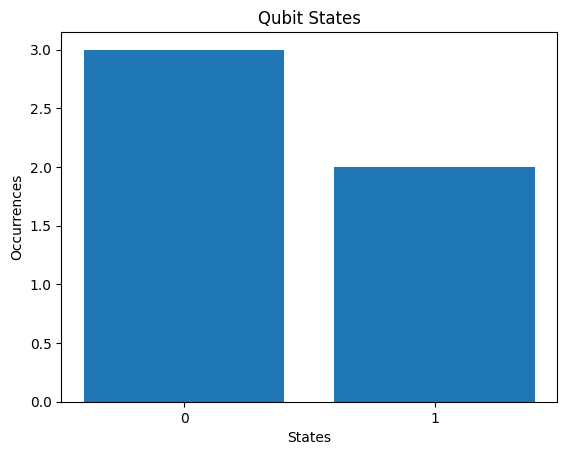

In [ ]:
hist = cirq.plot_state_histogram(result, plt.subplot(), title = 'Qubit States', xlabel = 'States', ylabel = 'Occurrences')
plt.show()

#### **Problem #1.5**

Create and print a circuit that applies 1 H gate, 1 X gate, another H gate, and a measurement to a single qubit.

Then simulate this circuit with 100 repetitions and print the results.

Lastly, visualize the results with a histogram.

In [ ]:
# COMPLETE THIS CODE

In [ ]:
# COMPLETE THIS CODE

In [ ]:
# COMPLETE THIS CODE

<a name="p2"></a>

---
## **Part 2: BB84 with Alice and Bob**
---

In this part, we will implement the BB84 protocol between Alice and Bob. We will see how to implement Eve's role next week.

#### **Problem #2.1**

Let's start by creating a `BB84` object and ensuring the following attributes have been created:

* `qubit`
* `simulator`

In [ ]:
my_protocol = BB84()

my_protocol.qubit = # COMPLETE THIS CODE
my_protocol.simulator = # COMPLETE THIS CODE

#### **Problem #2.2**

Now, let's create a circuit that represents Alice encoding a 0 into a qubit and not applying an H gate.

<br>

This should be stored the `my_protocol.alice_send_0_no_H_circuit` attribute.

In [ ]:
circuit = cirq.Circuit()

# COMPLETE THIS CODE

my_protocol.alice_send_0_no_H_circuit = circuit

#### **Problem #2.3**

Now, let's create a circuit that represents Bob not applying an H gate and then measuring.

<br>

This should be stored the `my_protocol.bob_receive_no_H_circuit` attribute.

In [ ]:
# COMPLETE THIS CODE

#### **Problem #2.4**

Lastly, let's test our code out by using the `my_protocol.send_bit(...)` method. Make sure to provide the following parameters to use our code from above:

* `alice_bit = 0`
* `does_alice_apply_H = 'no'`
* `does_bob_apply_H = 'no'`

<br>

**NOTE**: If everything has been coded correctly, you should see a "script" for this attempt to send a bit.

In [ ]:
my_protocol.send_bit(alice_bit=0, # COMPLETE THIS CODE

#### **Reflection**

* Did Alice and Bob end up using this bit in their key and is it the same value (0 or 1)?

* Will this always be the case provided Alice and Bob make the same choices. In other words, if you run the code again should you expect the same result every time?

#### **Problem #2.5**

Confirm your reflection answers by sending another bit with the same criteria (0 and no H's) 3 more times.

In [ ]:
# COMPLETE THIS CODE

#### **Problem #2.6**

At this point, Alice and Bob should both have keys that are 4 bits long that they believe are the same. However, they have not compared any bits to check for an eavesdropper yet.

<br>

In the cell below, send another bit with the same criteria but also specifying that the parameter `compare_bits = 'yes'`.

In [ ]:
my_protocol.send_bit(alice_bit=0, does_alice_apply_H='no', does_bob_apply_H='no', compare_bits = 'yes')

ATTEMPTED BIT 5 

PHASE 1: SENDING
Alice (to herself): I sent a 0 and did not use an H

PHASE 2: RECEIVING
Bob (to himself): I did not use an H and measured a 0

PHASE 3: COMPARING
Alice and Bob are comparing choice of H's and the bits themselves. 

Alice: I did not use an H
Bob: I did not use an H

Alice: I sent a 0
Bob: I measured a 0 

Alice and Bob: Our bits match, so it doesn't seem like Eve is intercepting.

Alice (to herself): My key is now [0, 0, 0, 0]
Bob (to himself): My key is now [0, 0, 0, 0]

The circuit used this round: q0: ───I───I───I───M───



#### **Reflection**

* Did Alice and Bob detect an eavesdropper here? Should they have?

* Did Alice and Bob add this bit to their keys? Should they have?

#### **Problem #2.7**

Now, try sending a bit such that:
* Alice sends a 1.
* Alice and Bob both do not use an H.
* They do not compare bits.

In [ ]:
# COMPLETE THIS CODE

#### **Problem #2.8**

You should have run into an error. In the space below, fix this error and try sending the bit again.

In [ ]:
# COMPLETE THIS CODE

In [ ]:
# COMPLETE THIS CODE

#### **Problem #2.9**

In the space below, define the remaining attributes:

* `alice_send_0_H_circuit`
* `alice_send_1_H_circuit`
* `bob_receive_H_circuit`

In [ ]:
# COMPLETE THIS CODE

In [ ]:
# COMPLETE THIS CODE

In [ ]:
# COMPLETE THIS CODE

#### **Problem #2.10**

Now, perform the following transmissions (in this order):

* Alice sends a 0 with an H gate and Bob does not use an H gate.
* Alice sends a 1 with an H gate and Bob does not use an H gate.
* Alice sends a 1 with an H gate and Bob does use an H gate.

<br>

**NOTE**: To ensure either Alice or Bob uses an H gate, you can set the corresponding parameter to `'yes'` instead of `'no'`.

In [ ]:
# COMPLETE THIS CODE

<a name="p3"></a>

---
## **Part 3: Homework**
---

Make sure you run the hidden code cell at the very top of the notebook to load the BB84 class definition.

#### **Problem #3.1**

To start, define a `BB84` object and modify all the circuit attributes to use the correct attributes. In other words, copy your answers from above into the space below.

In [ ]:
# Create the BB84 object
#=======================
my_protocol = # COMPLETE THIS CODE

my_protocol.qubit = # COMPLETE THIS CODE
my_protocol.simulator = # COMPLETE THIS CODE


# Alice Sending
#===============

# 0 without H
circuit = # COMPLETE THIS CODE

circuit.append(# COMPLETE THIS CODE
circuit.append(# COMPLETE THIS CODE

my_protocol.alice_send_0_no_H_circuit = # COMPLETE THIS CODE


# 0 with H
# COMPLETE THIS CODE


# 1 without H
# COMPLETE THIS CODE

# 1 with H
# COMPLETE THIS CODE



# Bob Receiving
#===============

# without H
# COMPLETE THIS CODE


# with H
# COMPLETE THIS CODE

#### **Problem #3.2**

Using the `my_protocol` object that you created in the cell above, perform the following transmissions:

* Alice sends a 0 using an H gate, Bob receives without an H gate.
* Alice sends a 1 without using an H gate, Bob receives without an H gate.
* Alice sends a 1 using an H gate, Bob receives using an H gate.
* Alice sends a 0 using an H gate, Bob receives without an H gate.
* Alice sends a 1 without using an H gate, Bob receives using an H gate.
* Alice sends a 0 without using an H gate, Bob receives without an H gate.

In [ ]:
my_protocol.# COMPLETE THIS CODE

#### **Problem #3.3**

In the space below, we send transmissions such that Alice's and Bob's choices of using an H gate are actually random (using [python's `random.choice(...)` method](https://www.w3schools.com/python/ref_random_choice.asp) if you are curious).

<br>

In #10 of this week's multiple choice question set, answer the following question: **What is the *least* and *most* number of bits that Alice and Bob might use in the end?**

In [ ]:
import random

my_protocol.restart()

my_protocol.send_bit(alice_bit=0, does_alice_apply_H=random.choice(['yes', 'no']), does_bob_apply_H=random.choice(['yes', 'no']))
my_protocol.send_bit(alice_bit=0, does_alice_apply_H=random.choice(['yes', 'no']), does_bob_apply_H=random.choice(['yes', 'no']))
my_protocol.send_bit(alice_bit=0, does_alice_apply_H=random.choice(['yes', 'no']), does_bob_apply_H=random.choice(['yes', 'no']))
my_protocol.send_bit(alice_bit=0, does_alice_apply_H=random.choice(['yes', 'no']), does_bob_apply_H=random.choice(['yes', 'no']))
my_protocol.send_bit(alice_bit=0, does_alice_apply_H=random.choice(['yes', 'no']), does_bob_apply_H=random.choice(['yes', 'no']))

ATTEMPTED BIT 1 

PHASE 1: SENDING
Alice (to herself): I sent a 0 and did not use an H

PHASE 2: RECEIVING
Bob (to himself): I did not use an H and measured a 0

PHASE 3: COMPARING
Alice and Bob are comparing choice of H's but not the bits themselves. 

Alice: I did not use an H
Bob: I did not use an H

Alice and Bob: Great, let's add this bit to our keys.

Alice (to herself): My key is now [0]
Bob (to himself): My key is now [0]

The circuit used this round: q0: ───I───I───I───M───

ATTEMPTED BIT 2 

PHASE 1: SENDING
Alice (to herself): I sent a 0 and used an H

PHASE 2: RECEIVING
Bob (to himself): I did not use an H and measured a 0

PHASE 3: COMPARING
Alice and Bob are comparing choice of H's but not the bits themselves. 

Alice: I used an H
Bob: I did not use an H

Alice and Bob: We made different choices, we should not use this bit.

Alice (to herself): My key is now [0]
Bob (to himself): My key is now [0]

The circuit used this round: q0: ───I───H───I───M───

ATTEMPTED BIT 3 

PH

# End of Notebook

---
© 2024 The Coding School, All rights reserved